In [667]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import jcopdl
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

- bs = batch size
- crop size = ukurannya harus sama
- kalau di CNN datanya NCHW
- dilakukan data augmentasi
- data test tidak perlu diaugmentasi namun perlu diresize baru kemudian dicrop

In [668]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [669]:
bs = 16
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale = (0.9, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("oilspill_dataset_fix/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=1)

test_set = datasets.ImageFolder("oilspill_dataset_fix/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [670]:
feature, target = next (iter(trainloader))
feature.shape

torch.Size([16, 3, 128, 128])

In [671]:
label2cat = train_set.classes
label2cat

['nospill', 'oilspill']

# Arsitektur dan Config

- feature extractor
- flatten 
- fully connected neural network

In [716]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            #Convolutional block 1
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            #Convolutional block 2
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            #Convolutional block 3
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            #Convolutional block 4
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            #Convolutional block 5
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            #Flattening
            nn.Flatten()
        ) 
        
        #Fully connected layer
        self.fc = nn.Sequential(
            #Linear 1024 -> 256
            nn.Linear(2048,256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            #Linear 256 -> 2
            nn.Linear(256, 2),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x
        

In [717]:
config = set_config({
    "batch_size" : bs,
    "crop_size": crop_size
})

# Training Preparation --> MCOC

In [718]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model", early_stop_patience=  10)

# Training

In [719]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6943 | Test_cost  = 0.6934 | Train_score = 0.4619 | Test_score = 0.4490 |




Epoch     2
Train_cost  = 0.6933 | Test_cost  = 0.6931 | Train_score = 0.5025 | Test_score = 0.4490 |
==> EarlyStop patience =  1 | Best test_score: 0.4490




Epoch     3
Train_cost  = 0.6932 | Test_cost  = 0.6937 | Train_score = 0.4975 | Test_score = 0.4490 |
==> EarlyStop patience =  2 | Best test_score: 0.4490




Epoch     4
Train_cost  = 0.6933 | Test_cost  = 0.6932 | Train_score = 0.4721 | Test_score = 0.4694 |




Epoch     5
Train_cost  = 0.6930 | Test_cost  = 0.6932 | Train_score = 0.5330 | Test_score = 0.5102 |




Epoch     6
Train_cost  = 0.6926 | Test_cost  = 0.6936 | Train_score = 0.5431 | Test_score = 0.4490 |
==> EarlyStop patience =  1 | Best test_score: 0.5102




Epoch     7
Train_cost  = 0.6926 | Test_cost  = 0.6935 | Train_score = 0.5584 | Test_score = 0.4898 |
==> EarlyStop patience =  2 | Best test_score: 0.5102




Epoch     8
Train_cost  = 0.6921 | Test_cost  = 0.6917 | Train_score = 0.4975 | Test_score = 0.5714 |




Epoch     9
Train_cost  = 0.6923 | Test_cost  = 0.6907 | Train_score = 0.5178 | Test_score = 0.5714 |
==> EarlyStop patience =  1 | Best test_score: 0.5714




Epoch    10
Train_cost  = 0.6911 | Test_cost  = 0.6937 | Train_score = 0.5127 | Test_score = 0.5102 |
==> EarlyStop patience =  2 | Best test_score: 0.5714




Epoch    11
Train_cost  = 0.6898 | Test_cost  = 0.6905 | Train_score = 0.5228 | Test_score = 0.4898 |
==> EarlyStop patience =  3 | Best test_score: 0.5714




Epoch    12
Train_cost  = 0.6886 | Test_cost  = 0.6938 | Train_score = 0.5787 | Test_score = 0.5510 |
==> EarlyStop patience =  4 | Best test_score: 0.5714




Epoch    13
Train_cost  = 0.6831 | Test_cost  = 0.6879 | Train_score = 0.5990 | Test_score = 0.4898 |
==> EarlyStop patience =  5 | Best test_score: 0.5714




Epoch    14
Train_cost  = 0.6732 | Test_cost  = 0.6848 | Train_score = 0.6548 | Test_score = 0.5714 |
==> EarlyStop patience =  6 | Best test_score: 0.5714




Epoch    15
Train_cost  = 0.6565 | Test_cost  = 0.6690 | Train_score = 0.6701 | Test_score = 0.5306 |
==> EarlyStop patience =  7 | Best test_score: 0.5714




Epoch    16
Train_cost  = 0.6318 | Test_cost  = 0.6657 | Train_score = 0.6548 | Test_score = 0.5714 |
==> EarlyStop patience =  8 | Best test_score: 0.5714
==> Execute Early Stopping at epoch: 16 | Best test_score: 0.5714
==> Best model is saved at model


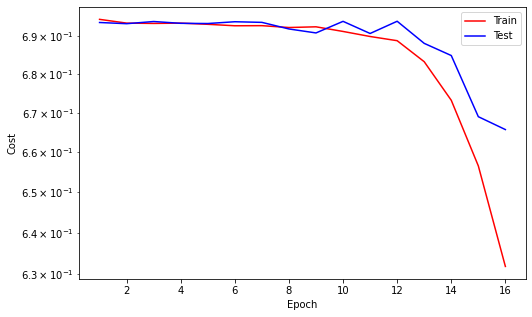

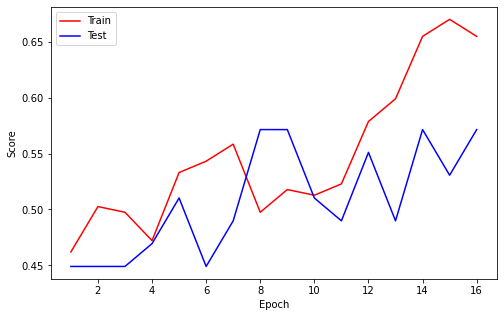

In [720]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [721]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [722]:
with torch.no_grad():
    model.eval()
    output = model (feature)
    preds = output
preds

tensor([[-0.6807, -0.7058],
        [-0.7007, -0.6857],
        [-0.6815, -0.7049],
        [-0.6747, -0.7119],
        [-0.6835, -0.7029],
        [-0.6833, -0.7031],
        [-0.6791, -0.7074],
        [-0.6770, -0.7096],
        [-0.6809, -0.7055],
        [-0.6758, -0.7108],
        [-0.6764, -0.7102],
        [-0.6864, -0.6999],
        [-0.6859, -0.7004],
        [-0.6893, -0.6970],
        [-0.6792, -0.7073],
        [-0.6806, -0.7058]])

# Probability and classification

In [713]:
np.exp(preds), preds.argmax(1)

(tensor([[0.4990, 0.5010],
         [0.4617, 0.5383],
         [0.5291, 0.4709],
         [0.4288, 0.5712],
         [0.4727, 0.5273],
         [0.4975, 0.5025],
         [0.5679, 0.4321],
         [0.4963, 0.5037],
         [0.4227, 0.5773],
         [0.5245, 0.4755],
         [0.4821, 0.5179],
         [0.4557, 0.5443],
         [0.5405, 0.4595],
         [0.5217, 0.4783],
         [0.5279, 0.4721],
         [0.4968, 0.5032]]),
 tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1]))

In [714]:
max(np.exp(preds[0]))

tensor(0.5010)

# Sanity check

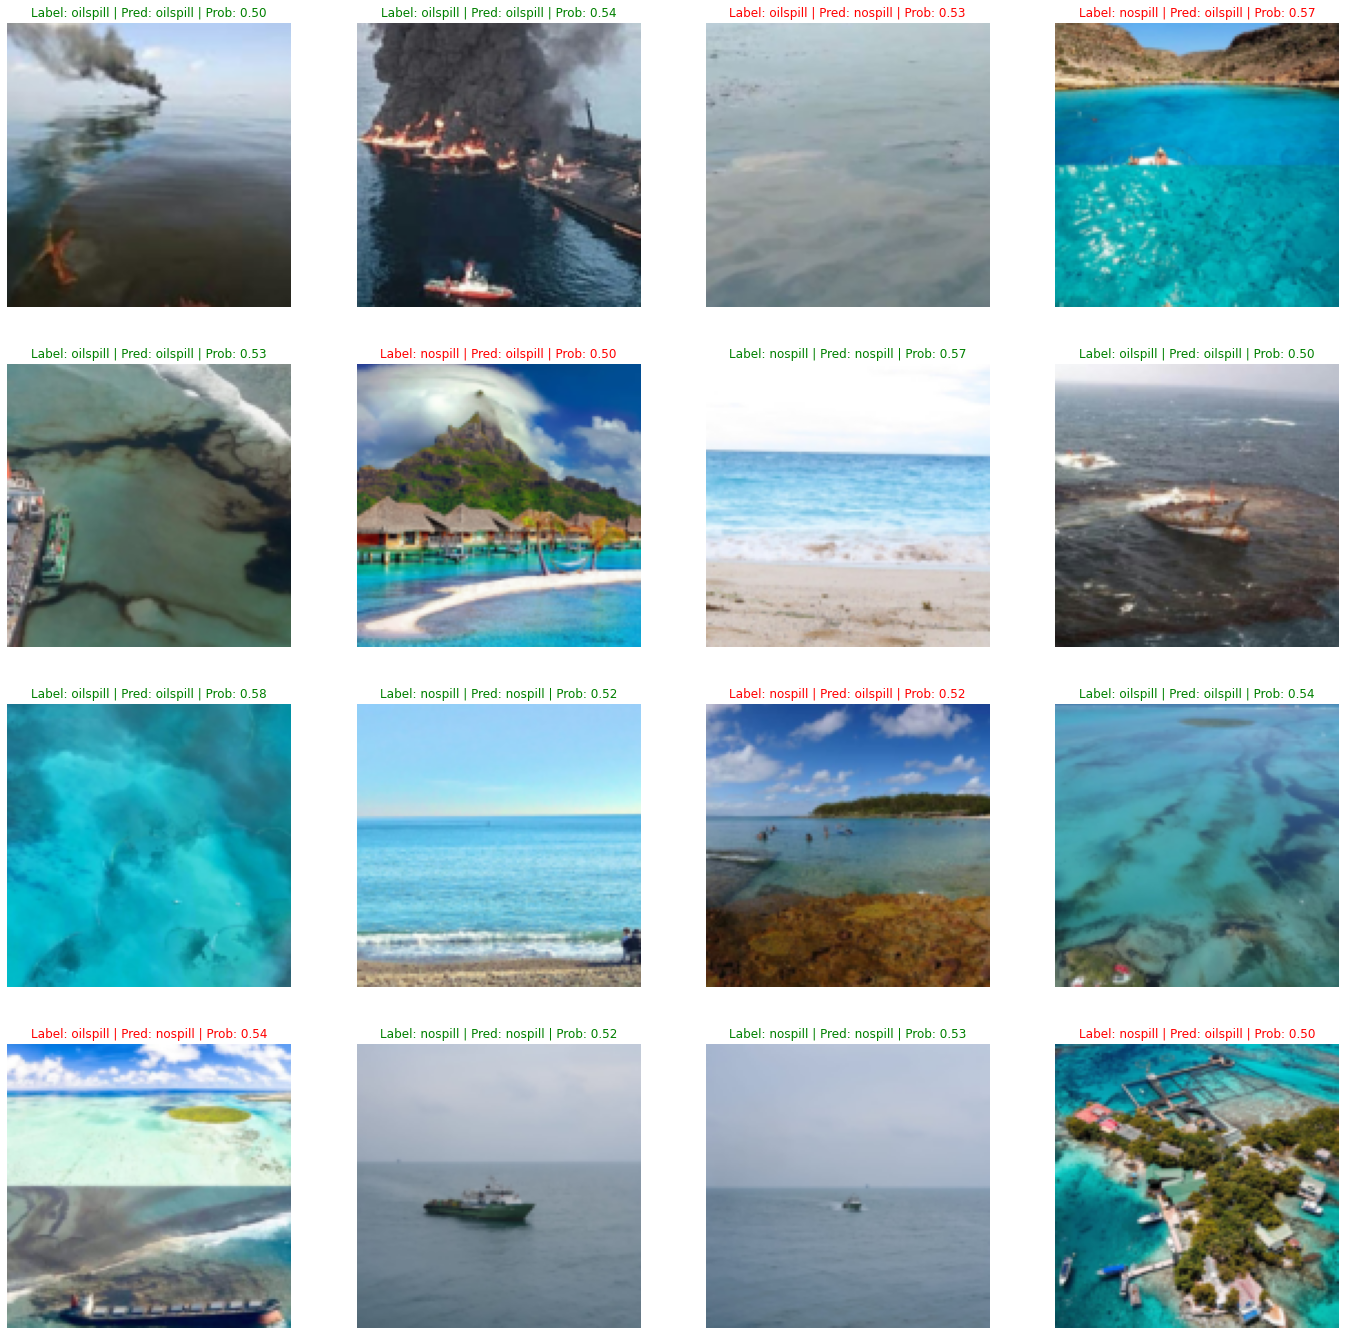

In [715]:
fig, axes = plt.subplots(4,4, figsize = (24,24))

for img, label, pred, ax in zip (feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color": 'r'} if label != pred.argmax(0) else {"color":'g'}
    label, pred, prob = label2cat [label.item()], label2cat[pred.argmax(0).item()], "{:.2f}".format(max(np.exp(pred)).item())
    ax.set_title(f"Label: {label} | Pred: {pred} | Prob: {prob}", fontdict= font)
    ax.axis("off")

In [621]:
fig.savefig("oilspill.png")

# new image
- https://discuss.pytorch.org/t/how-to-classify-single-image-using-loaded-net/1411/2

In [591]:
crop_size = 128
loader = transforms.Compose([
            transforms.Resize(70),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor()])

In [599]:
from PIL import Image
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

In [600]:
images = image_loader("new_image/test3.jpg")
images.shape

torch.Size([1, 3, 128, 128])

In [601]:
with torch.no_grad():
    model.eval()
    output = model (images)
    print(f"there is %s with probability %s" %(label2cat[output.argmax(1).item()], "{:.2f}".format(max(np.exp(output)[0]))))

there is oilspill with probability 0.70
